In [1]:
import keras
import tensorflow as tf
import pickle
from glob import glob
from more_itertools import chunked
import tensorflow_hub as hub
from keras.preprocessing import image
from keras.utils import load_img, img_to_array
import numpy as np


2023-01-26 23:49:46.222597: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
efnet = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2", trainable=False),
])
efnet.build([None, 480, 480, 3])

In [80]:
test_img = load_img('data/query_dog.png', target_size=(480, 480))
test_img = img_to_array(test_img)
test_img = np.array([test_img])

pred = efnet.predict(test_img)
pred.shape

1/1 [==============================] - 0s 116ms/step


(1, 1280)

In [9]:
buildings_train = glob('../buildings/*.jpg')
all_chunked = list(chunked(buildings_train, 25))

images_processed = []

for chunk_index, chunk in enumerate(all_chunked):

  print(f"Processing chunk {chunk_index}... of {len(all_chunked)}")

  img_list = []
  for path in chunk:
    img = load_img(path, target_size=(480, 480))
    img = img_to_array(img)
    img_list.append(img)
  
  preds = efnet.predict_on_batch(np.array(img_list))
  for index, path in enumerate(chunk):
    images_processed.append({
        'path': path,
        'feature_vector': preds[index]
    })

with open('data/buildings_vectors.pickle', 'wb') as f:
  pickle.dump(images_processed, f, protocol=pickle.HIGHEST_PROTOCOL)
print("Done")

Processing chunk 0... of 22


2023-01-26 22:42:14.175867: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-26 22:42:14.175923: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-26 22:42:16.567624: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-26 22:42:16.928961: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

Processing chunk 1... of 22
Processing chunk 2... of 22
Processing chunk 3... of 22
Processing chunk 4... of 22
Processing chunk 5... of 22
Processing chunk 6... of 22
Processing chunk 7... of 22
Processing chunk 8... of 22
Processing chunk 9... of 22
Processing chunk 10... of 22
Processing chunk 11... of 22
Processing chunk 12... of 22
Processing chunk 13... of 22
Processing chunk 14... of 22
Processing chunk 15... of 22
Processing chunk 16... of 22
Processing chunk 17... of 22
Processing chunk 18... of 22
Processing chunk 19... of 22
Processing chunk 20... of 22
Processing chunk 21... of 22


In [16]:
with open('data/buildings_vectors.pickle', 'rb') as f:
  images_processed = pickle.load(f)

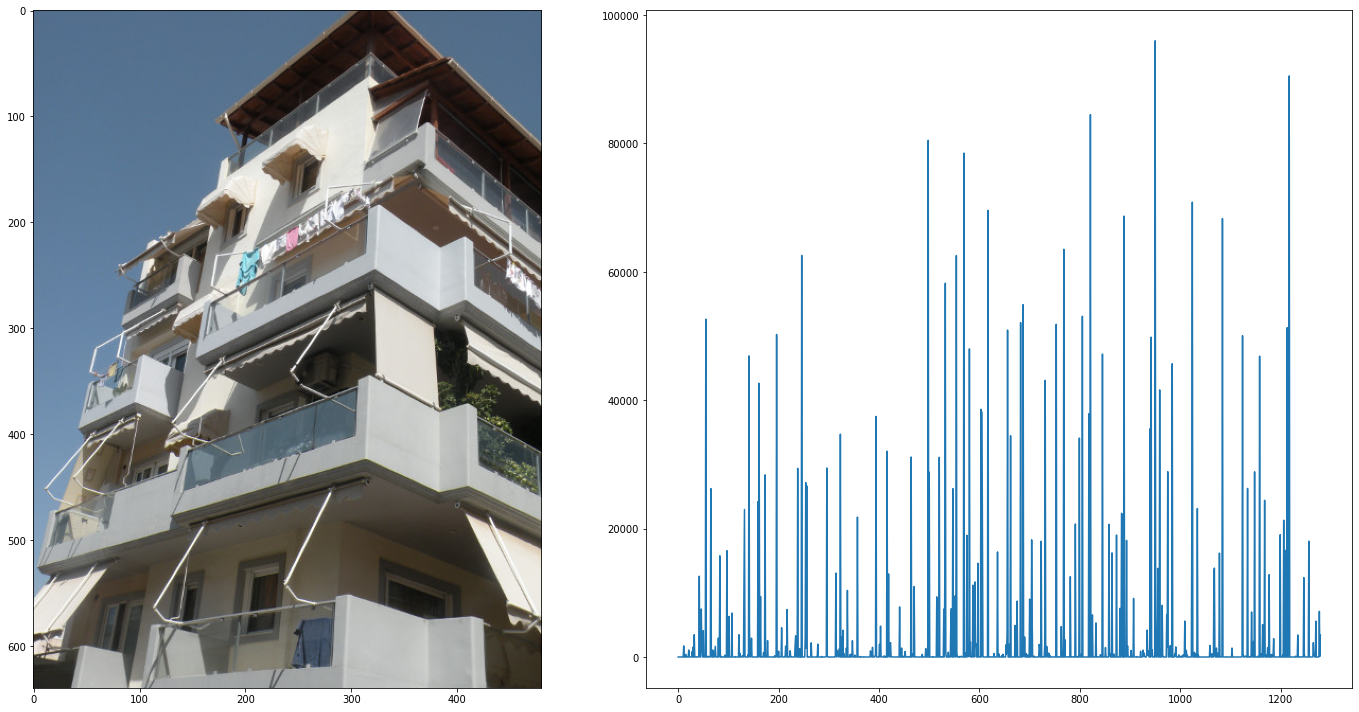

In [37]:
import cv2
import matplotlib.pyplot as plt

def plot(x):
  fig, ax = plt.subplots(1, 2, figsize=(20,10))
  img = cv2.imread(x['path'])
  ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  ax[1].plot(x['feature_vector'])
  fig.tight_layout()

plot(images_processed[0])

1/1 [==============================] - 5s 5s/step


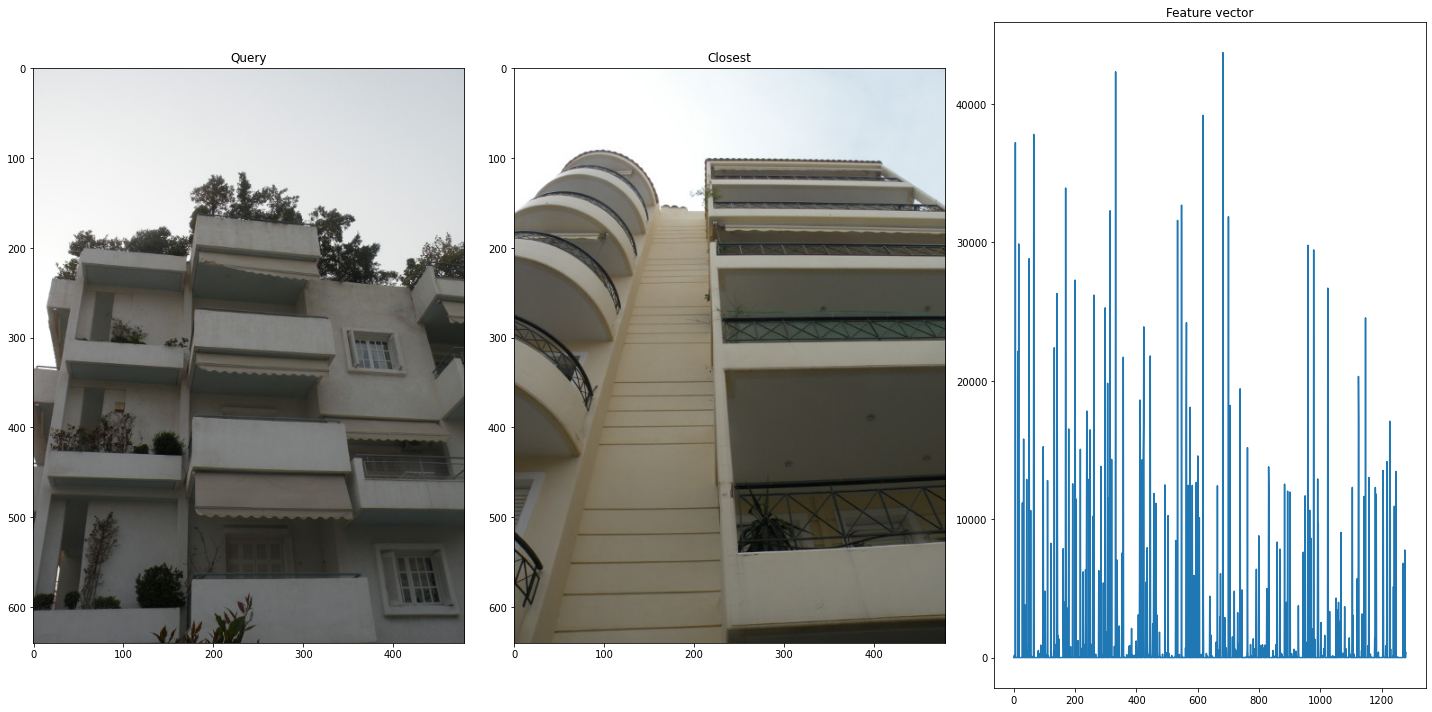

In [38]:
import scipy.spatial.distance as metrics

test_images = glob('../buildings/test/*.jpg')
random_test_image = np.random.choice(test_images)
img = load_img(random_test_image, target_size=(480, 480))
img = img_to_array(img)
img = np.array([img])
pred = efnet.predict(img)
distances = [metrics.cosine(pred[0], x['feature_vector']) for x in images_processed]
closest = np.argmin(distances)
fig, ax = plt.subplots(1, 3, figsize=(20,10))
img = cv2.imread(random_test_image)
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].set_title("Query")
img = cv2.imread(images_processed[closest]['path'])
ax[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1].set_title("Closest")
ax[2].plot(images_processed[closest]['feature_vector'])
ax[2].set_title("Feature vector")
fig.tight_layout()

In [68]:
y_true = []
y_pred = []

for img_path in test_images:
  building = img_path.split('/')[-1].split('_')[0]
  y_true.append(building)
  img = load_img(img_path, target_size=(480, 480))
  img = img_to_array(img)
  img = np.array([img])
  pred = efnet.predict(img)
  distances = [metrics.braycurtis(pred[0], x['feature_vector']) for x in images_processed]
  closest = np.argmin(distances)
  closest_building = images_processed[closest]['path'].split('/')[-1].split('_')[0]
  y_pred.append(closest_building)

  if building != closest_building:
    print(f"Wrong match: {building} != {closest_building}")
  else:
    print(f"Correct match: {building} == {closest_building}")

1/1 [==============================] - 0s 104ms/step
Wrong match: building14 != building26
1/1 [==============================] - 0s 108ms/step
Wrong match: building48 != building60
1/1 [==============================] - 0s 109ms/step
Correct match: building17 == building17
1/1 [==============================] - 0s 106ms/step
Wrong match: building15 != building01
1/1 [==============================] - 0s 106ms/step
Wrong match: building28 != building14
1/1 [==============================] - 0s 110ms/step
Wrong match: building09 != building30
1/1 [==============================] - 0s 103ms/step
Wrong match: building45 != building01
1/1 [==============================] - 0s 101ms/step
Wrong match: building59 != building30
1/1 [==============================] - 0s 101ms/step
Wrong match: building10 != building40
1/1 [==============================] - 0s 106ms/step
Wrong match: building01 != building11
1/1 [==============================] - 0s 102ms/step
Wrong match: building24 != building

<AxesSubplot: >

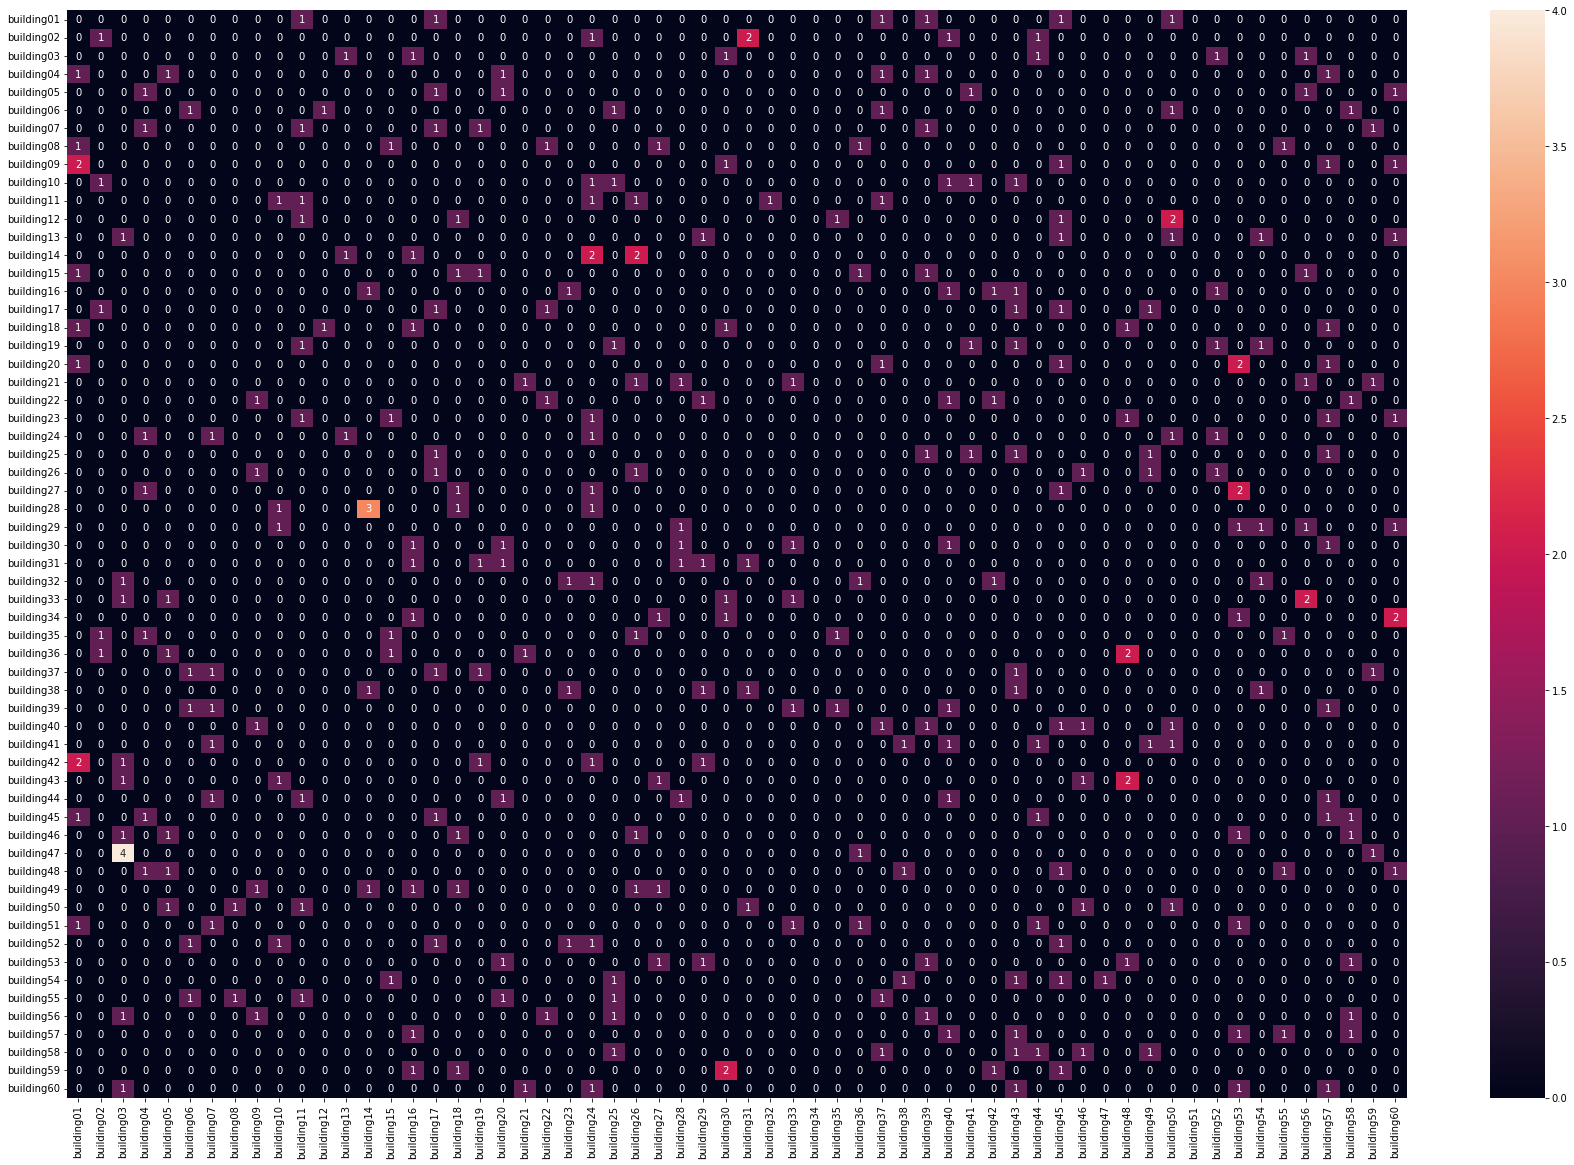

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(y_true)],
                  columns = [i for i in np.unique(y_true)])
plt.figure(figsize = (30,20))
sn.heatmap(df_cm, annot=True)

In [121]:
from keras import layers
from keras import Input

input_tensor_a = Input(shape=(1280,))
input_tensor_b = Input(shape=(1280,))

x = layers.Dense(32, activation='leaky_relu')(input_tensor_a)

y = layers.Dense(32, activation='leaky_relu')(input_tensor_b)

z = layers.concatenate([x, y])
z = layers.Dense(8, activation='leaky_relu')(z)
z = layers.Dense(1, activation='sigmoid')(z)

model = keras.Model([input_tensor_a, input_tensor_b], z)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 1280)]       0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 1280)]       0           []                               
                                                                                                  
 dense_35 (Dense)               (None, 64)           81984       ['input_17[0][0]']               
                                                                                                  
 dense_36 (Dense)               (None, 64)           81984       ['input_18[0][0]']               
                                                                                            

In [157]:
buildings_train = glob('../buildings/*.jpg')
import random

# pair each image with every other image
pairs = []
for img in images_processed:
  for img2 in images_processed:
    if img['path'] != img2['path']:
      pairs.append((img, img2, 1 if img['path'].split('/')[-1].split('_')[0] == img2['path'].split('/')[-1].split('_')[0] else 0))

pairs = pairs + [(x[1], x[0], x[2]) for x in pairs]

# make pairs with label 1 and 0 equal
amount_of_ones = len([x for x in pairs if x[2] == 1])
amount_of_zeros = len([x for x in pairs if x[2] == 0])

pairs_with_ones = [x for x in pairs if x[2] == 1]
pairs = pairs_with_ones + random.sample([x for x in pairs if x[2] == 0], amount_of_ones)

#also add reverse pairs
pairs = pairs + [(x[1], x[0], x[2]) for x in pairs]

In [158]:
random.shuffle(pairs)
len(pairs)

34560

In [159]:
chunks = chunked(pairs, 1024)
history = []
for chunk in chunks:
  x1 = []
  x2 = []
  y = []
  for pair in chunk:
    x1.append(pair[0]['feature_vector'])
    x2.append(pair[1]['feature_vector'])
    if pair[0]['path'].split('/')[-1].split('_')[0] == pair[1]['path'].split('/')[-1].split('_')[0]:
      y.append(1)
    else:
      y.append(0)
  history.append(model.fit([np.array(x1), np.array(x2)], np.array(y), epochs=10, batch_size=512))

Epoch 1/10
2/2 [==============================] - 0s 8ms/step - loss: 22.7974 - accuracy: 0.6113
Epoch 2/10
2/2 [==============================] - 0s 8ms/step - loss: 21.8895 - accuracy: 0.6416
Epoch 3/10
2/2 [==============================] - 0s 8ms/step - loss: 23.1963 - accuracy: 0.6133
Epoch 4/10
2/2 [==============================] - 0s 8ms/step - loss: 13.8241 - accuracy: 0.6895
Epoch 5/10
2/2 [==============================] - 0s 8ms/step - loss: 18.6004 - accuracy: 0.6680
Epoch 6/10
2/2 [==============================] - 0s 12ms/step - loss: 19.7402 - accuracy: 0.6436
Epoch 7/10
2/2 [==============================] - 0s 14ms/step - loss: 20.5698 - accuracy: 0.6553
Epoch 8/10
2/2 [==============================] - 0s 9ms/step - loss: 9.9402 - accuracy: 0.7480
Epoch 9/10
2/2 [==============================] - 0s 10ms/step - loss: 9.5926 - accuracy: 0.7373
Epoch 10/10
2/2 [==============================] - 0s 8ms/step - loss: 11.9705 - accuracy: 0.7178
Epoch 1/10
2/2 [============

In [160]:
model.save('data/buildings_model.h5')

In [161]:
from tensorflow import data
y_true = []
y_pred = []

all_fvs = [x['feature_vector'] for x in images_processed]

for img_path in test_images:
  building = img_path.split('/')[-1].split('_')[0]
  print(f"Query: {building}")
  
  y_true.append(building)
  img = load_img(img_path, target_size=(480, 480))
  img = img_to_array(img)
  img = np.array([img])
  pred = efnet.predict(img)[0]
  
  distances = []
  x1 = [pred for x in range(len(all_fvs))]
  x2 = all_fvs

  predictions = model.predict([np.array(x1), np.array(x2)], batch_size=1024)
  distances = [x[0] for x in predictions]
  
  closest = np.argmax(distances)
  closest_building = images_processed[closest]['path'].split('/')[-1].split('_')[0]
  y_pred.append(closest_building)

  if building != closest_building:
    print(f"Wrong match: {building} != {closest_building}")
  else:
    print(f"Correct match: {building} == {closest_building}")

Query: building14
1/1 [==============================] - 0s 32ms/step
Wrong match: building14 != building20
Query: building48
1/1 [==============================] - 0s 31ms/step
Wrong match: building48 != building34
Query: building17
1/1 [==============================] - 0s 28ms/step
Wrong match: building17 != building36
Query: building15
1/1 [==============================] - 0s 29ms/step
Wrong match: building15 != building20
Query: building28
1/1 [==============================] - 0s 29ms/step
Wrong match: building28 != building20
Query: building09
1/1 [==============================] - 0s 30ms/step
Wrong match: building09 != building07
Query: building45
1/1 [==============================] - 0s 29ms/step
Wrong match: building45 != building20
Query: building59
1/1 [==============================] - 0s 28ms/step
Wrong match: building59 != building07
Query: building10
1/1 [==============================] - 0s 29ms/step
Wrong match: building10 != building20
Query: building01
1/1 [=====

<AxesSubplot: >

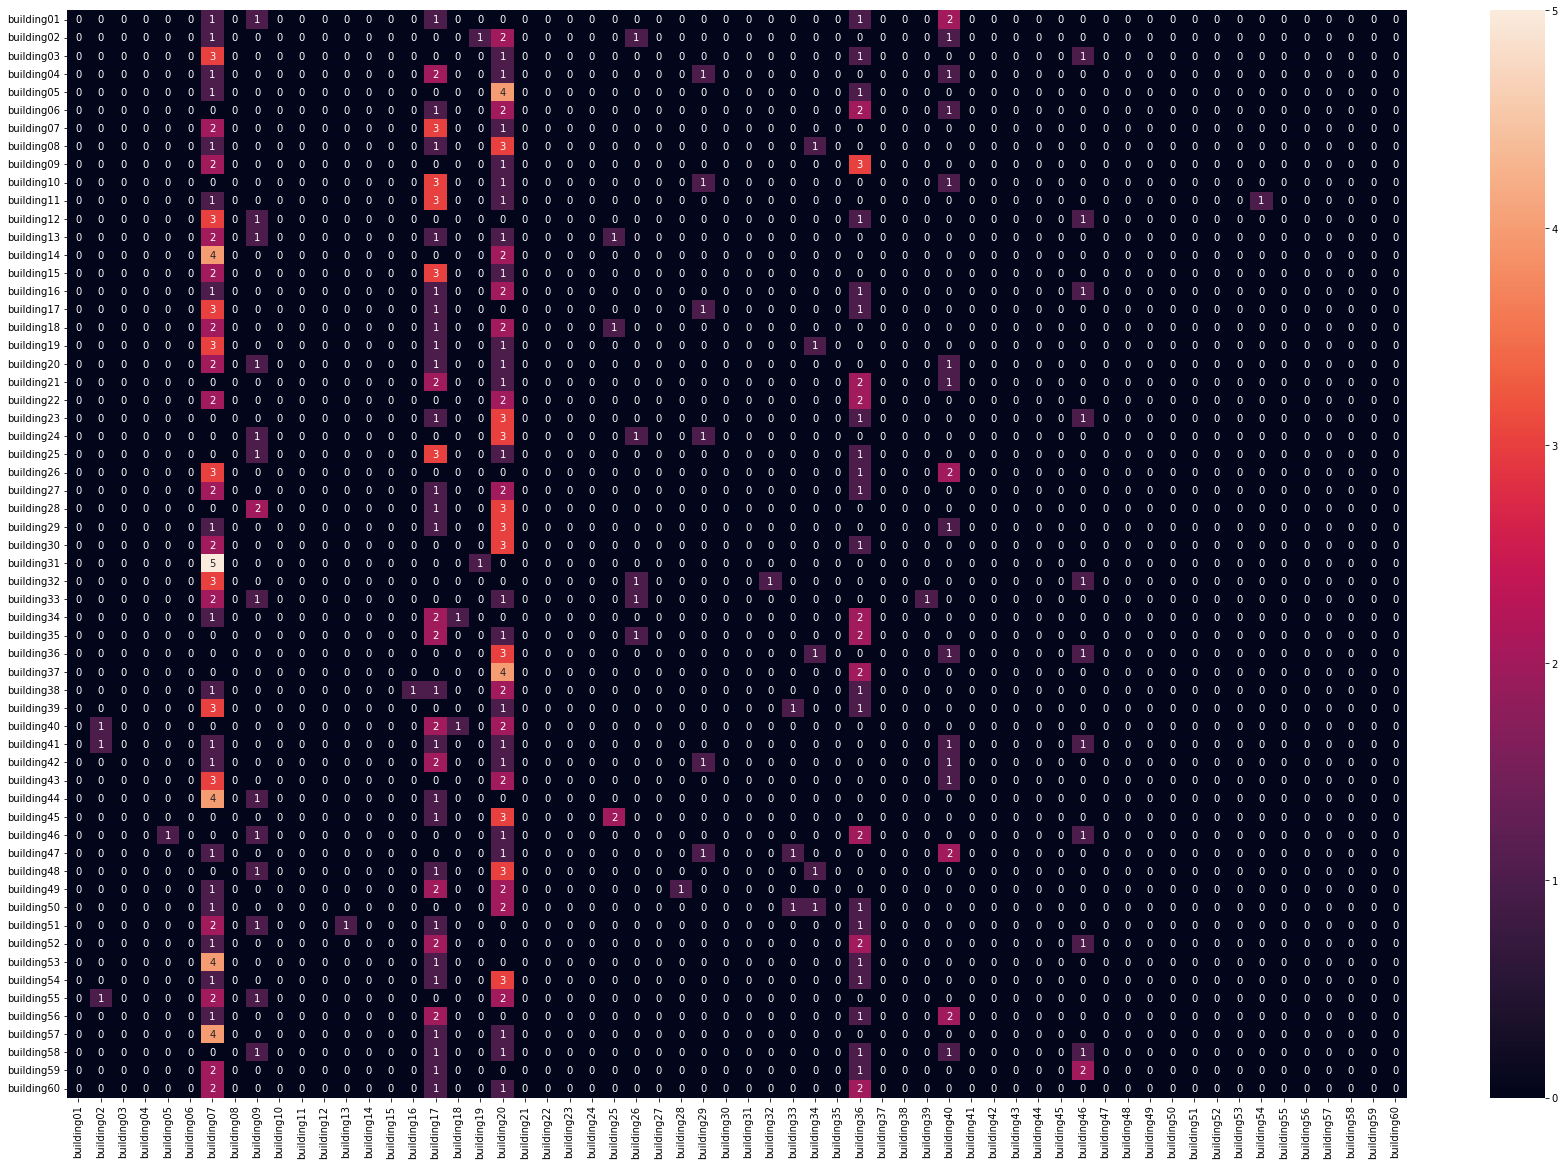

In [162]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(y_true)],
                  columns = [i for i in np.unique(y_true)])
plt.figure(figsize = (30,20))
sn.heatmap(df_cm, annot=True)

In [151]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=0)

x = []
y = []

for img in images_processed:
  x.append(img['feature_vector'])
  y.append(img['path'].split('/')[-1].split('_')[0])

clf.fit(x, y)

RandomForestClassifier(max_depth=10, n_estimators=300, random_state=0)

In [152]:
true_y = []
pred_y = []

for test_image in test_images:
  building = test_image.split('/')[-1].split('_')[0]
  print(f"Query: {building}")
  img = load_img(test_image, target_size=(480, 480))
  img = img_to_array(img)
  img = np.array([img])
  true_y.append(building)
  pred = efnet.predict(img, verbose=0)[0]
  pred = [pred]
  pred = clf.predict(pred)
  pred_y.append(pred[0])
  
  if building != pred[0]:
    print(f"Wrong match: {building} != {pred[0]}")
  else:
    print(f"Correct match: {building} == {pred[0]}")

Query: building14
Wrong match: building14 != building26
Query: building48
Wrong match: building48 != building03
Query: building17
Wrong match: building17 != building23
Query: building15
Wrong match: building15 != building07
Query: building28
Wrong match: building28 != building47
Query: building09
Wrong match: building09 != building20
Query: building45
Wrong match: building45 != building20
Query: building59
Wrong match: building59 != building30
Query: building10
Wrong match: building10 != building25
Query: building01
Wrong match: building01 != building11
Query: building24
Wrong match: building24 != building30
Query: building19
Wrong match: building19 != building07
Query: building16
Wrong match: building16 != building50
Query: building11
Wrong match: building11 != building09
Query: building15
Wrong match: building15 != building40
Query: building24
Wrong match: building24 != building44
Query: building48
Wrong match: building48 != building49
Query: building44
Wrong match: building44 != bui

<AxesSubplot: >

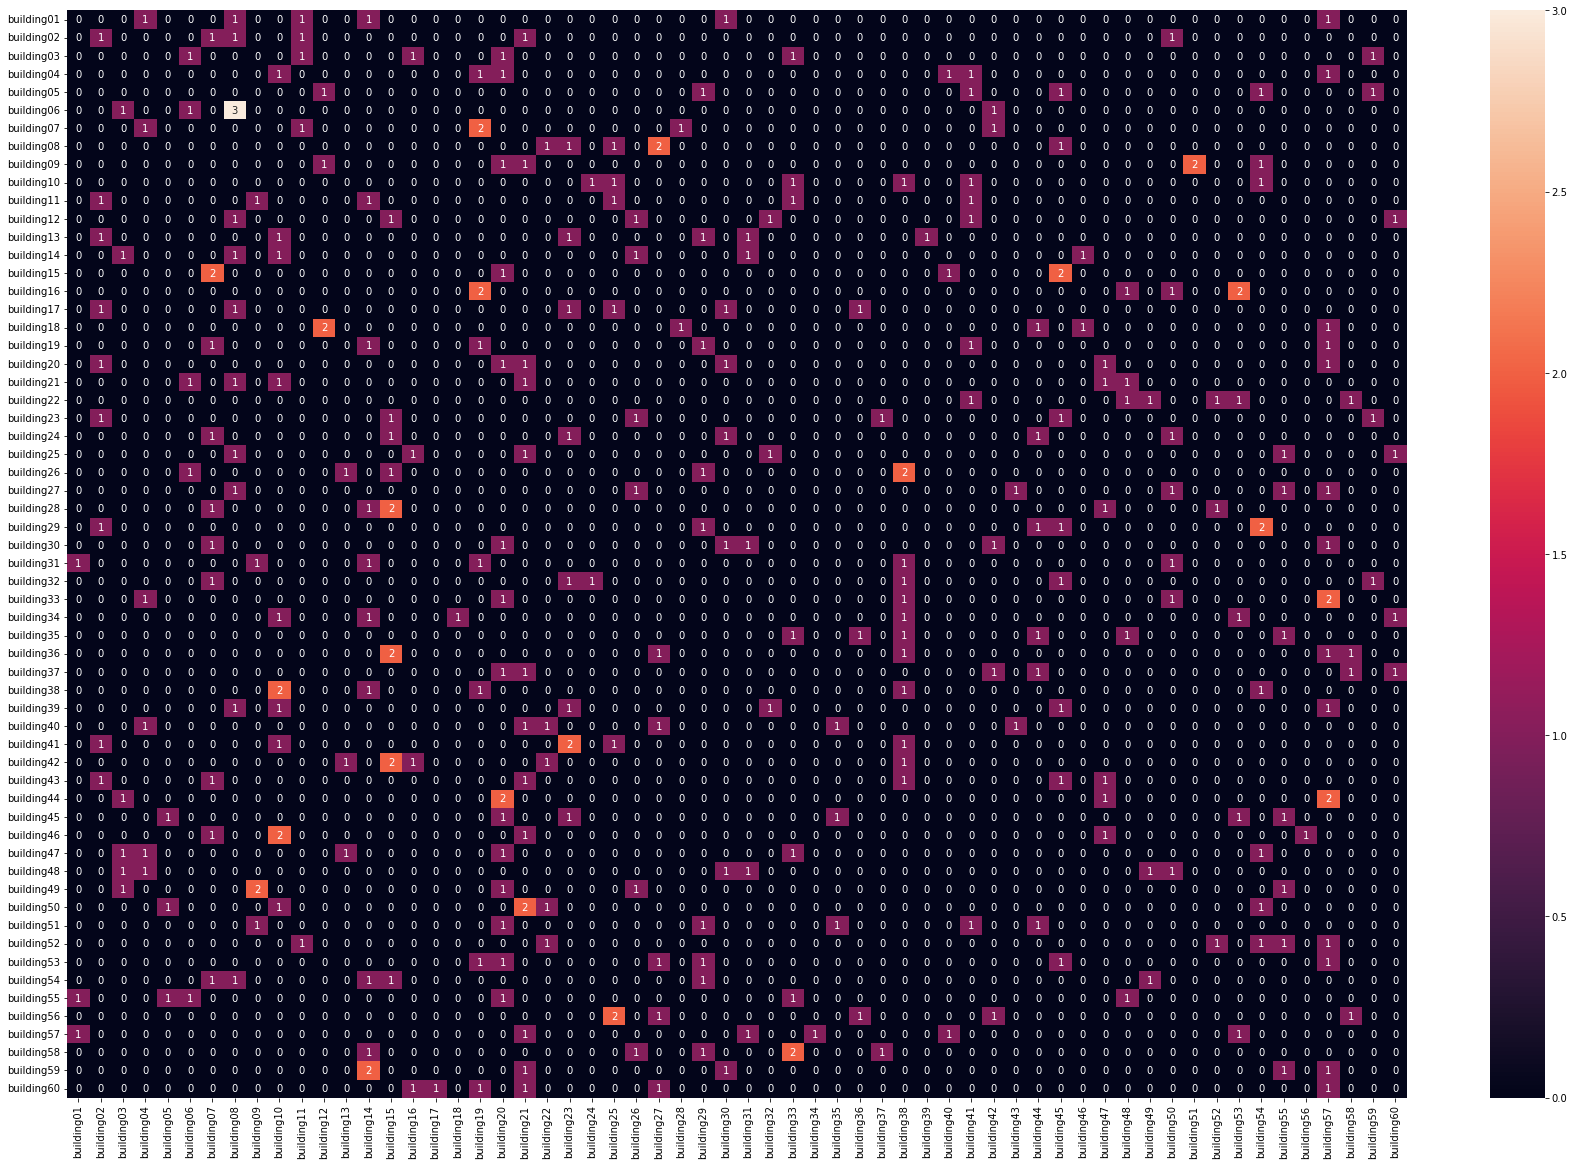

In [153]:
cm = confusion_matrix(true_y, pred_y)
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(true_y)],
                  columns = [i for i in np.unique(true_y)])
plt.figure(figsize = (30,20))
sn.heatmap(df_cm, annot=True)

In [154]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)

x = []
y = []

for img in images_processed:
  x.append(img['feature_vector'])
  y.append(img['path'].split('/')[-1].split('_')[0])

neigh.fit(x, y)

KNeighborsClassifier(n_neighbors=3)

In [155]:
true_y = []
pred_y = []

for test_image in test_images:
  building = test_image.split('/')[-1].split('_')[0]
  print(f"Query: {building}")
  img = load_img(test_image, target_size=(480, 480))
  img = img_to_array(img)
  img = np.array([img])
  true_y.append(building)
  pred = efnet.predict(img, verbose=0)[0]
  pred = [pred]
  pred = neigh.predict(pred)
  pred_y.append(pred[0])
  
  if building != pred[0]:
    print(f"Wrong match: {building} != {pred[0]}")
  else:
    print(f"Correct match: {building} == {pred[0]}")

Query: building14
Wrong match: building14 != building25
Query: building48
Wrong match: building48 != building18
Query: building17
Wrong match: building17 != building04
Query: building15
Wrong match: building15 != building23
Query: building28
Wrong match: building28 != building14
Query: building09
Wrong match: building09 != building20
Query: building45
Wrong match: building45 != building01
Query: building59
Wrong match: building59 != building08
Query: building10
Wrong match: building10 != building04
Query: building01
Wrong match: building01 != building11
Query: building24
Wrong match: building24 != building07
Query: building19
Wrong match: building19 != building07
Query: building16
Wrong match: building16 != building08
Query: building11
Wrong match: building11 != building09
Query: building15
Wrong match: building15 != building23
Query: building24
Wrong match: building24 != building11
Query: building48
Wrong match: building48 != building03
Query: building44
Wrong match: building44 != bui

<AxesSubplot: >

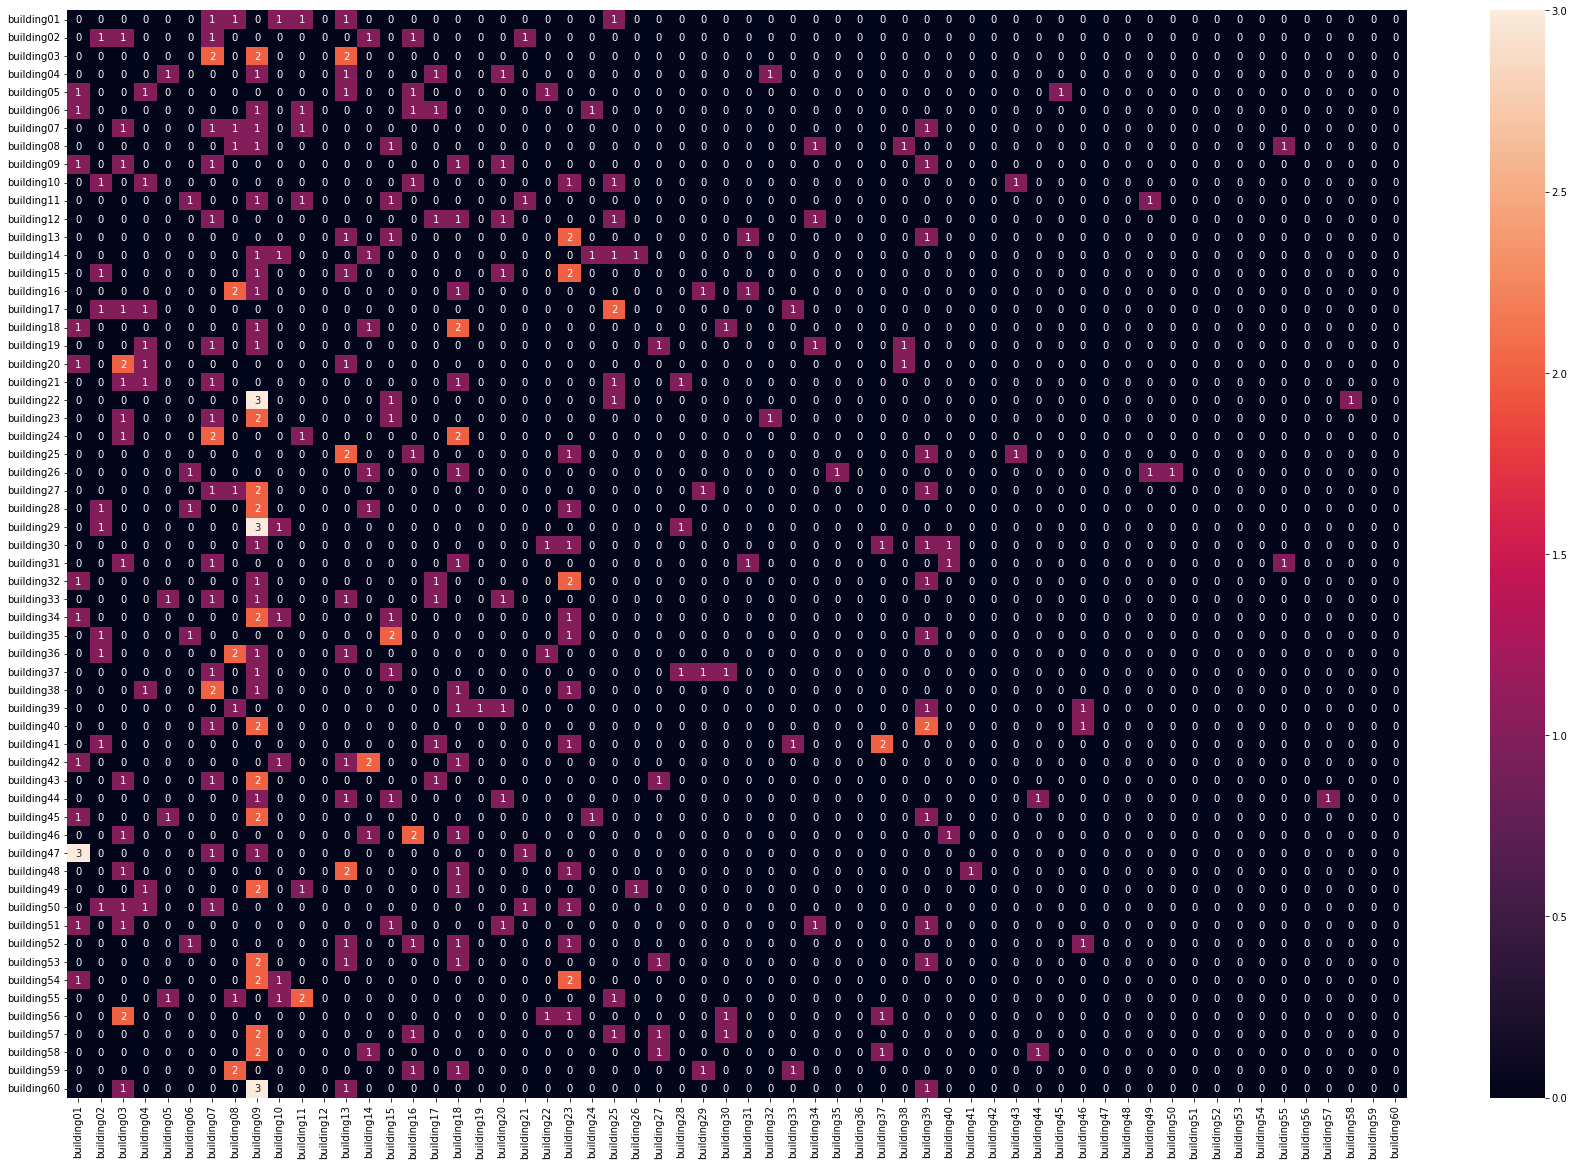

In [156]:
cm = confusion_matrix(true_y, pred_y)
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(true_y)],
                  columns = [i for i in np.unique(true_y)])
plt.figure(figsize = (30,20))
sn.heatmap(df_cm, annot=True)

In [164]:
bitnet = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/experts/bit/r50x1/in21k/structure/1", trainable=False),
])
bitnet.build([None, 480, 480, 3])

In [165]:
buildings_train = glob('../buildings/*.jpg')
all_chunked = list(chunked(buildings_train, 25))

images_processed = []

for chunk_index, chunk in enumerate(all_chunked):

  print(f"Processing chunk {chunk_index}... of {len(all_chunked)}")

  img_list = []
  for path in chunk:
    img = load_img(path, target_size=(480, 480))
    img = img_to_array(img)
    img_list.append(img)
  
  preds = bitnet.predict_on_batch(np.array(img_list))
  for index, path in enumerate(chunk):
    images_processed.append({
        'path': path,
        'feature_vector': preds[index]
    })

with open('data/buildings_vectors_bitnet.pickle', 'wb') as f:
  pickle.dump(images_processed, f, protocol=pickle.HIGHEST_PROTOCOL)
print("Done")

Processing chunk 0... of 22
Processing chunk 1... of 22
Processing chunk 2... of 22
Processing chunk 3... of 22
Processing chunk 4... of 22
Processing chunk 5... of 22
Processing chunk 6... of 22
Processing chunk 7... of 22
Processing chunk 8... of 22
Processing chunk 9... of 22
Processing chunk 10... of 22
Processing chunk 11... of 22
Processing chunk 12... of 22
Processing chunk 13... of 22
Processing chunk 14... of 22
Processing chunk 15... of 22
Processing chunk 16... of 22
Processing chunk 17... of 22
Processing chunk 18... of 22
Processing chunk 19... of 22
Processing chunk 20... of 22
Processing chunk 21... of 22
Done


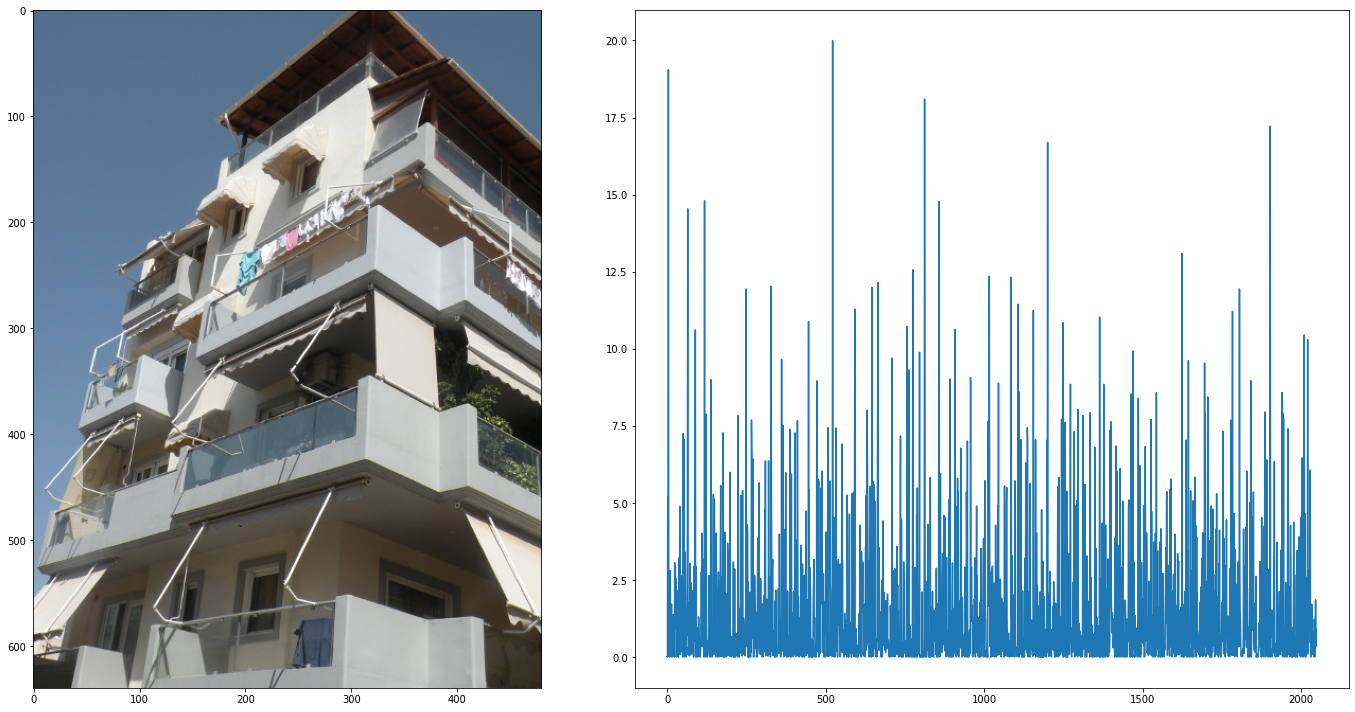

In [166]:
import cv2
import matplotlib.pyplot as plt

def plot(x):
  fig, ax = plt.subplots(1, 2, figsize=(20,10))
  img = cv2.imread(x['path'])
  ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  ax[1].plot(x['feature_vector'])
  fig.tight_layout()

plot(images_processed[0])

In [168]:
y_true = []
y_pred = []

for img_path in test_images:
  building = img_path.split('/')[-1].split('_')[0]
  y_true.append(building)
  img = load_img(img_path, target_size=(480, 480))
  img = img_to_array(img)
  img = np.array([img])
  pred = bitnet.predict(img)
  distances = [metrics.braycurtis(pred[0], x['feature_vector']) for x in images_processed]
  closest = np.argmin(distances)
  closest_building = images_processed[closest]['path'].split('/')[-1].split('_')[0]
  y_pred.append(closest_building)

  if building != closest_building:
    print(f"Wrong match: {building} != {closest_building}")
  else:
    print(f"Correct match: {building} == {closest_building}")

1/1 [==============================] - 3s 3s/step
Correct match: building14 == building14
1/1 [==============================] - 0s 34ms/step
Correct match: building48 == building48
1/1 [==============================] - 0s 34ms/step
Correct match: building17 == building17
1/1 [==============================] - 0s 42ms/step
Correct match: building15 == building15
1/1 [==============================] - 0s 35ms/step
Correct match: building28 == building28
1/1 [==============================] - 0s 36ms/step
Correct match: building09 == building09
1/1 [==============================] - 0s 37ms/step
Correct match: building45 == building45
1/1 [==============================] - 0s 35ms/step
Correct match: building59 == building59
1/1 [==============================] - 0s 33ms/step
Correct match: building10 == building10
1/1 [==============================] - 0s 32ms/step
Correct match: building01 == building01
1/1 [==============================] - 0s 33ms/step
Correct match: building24 == b

<AxesSubplot: >

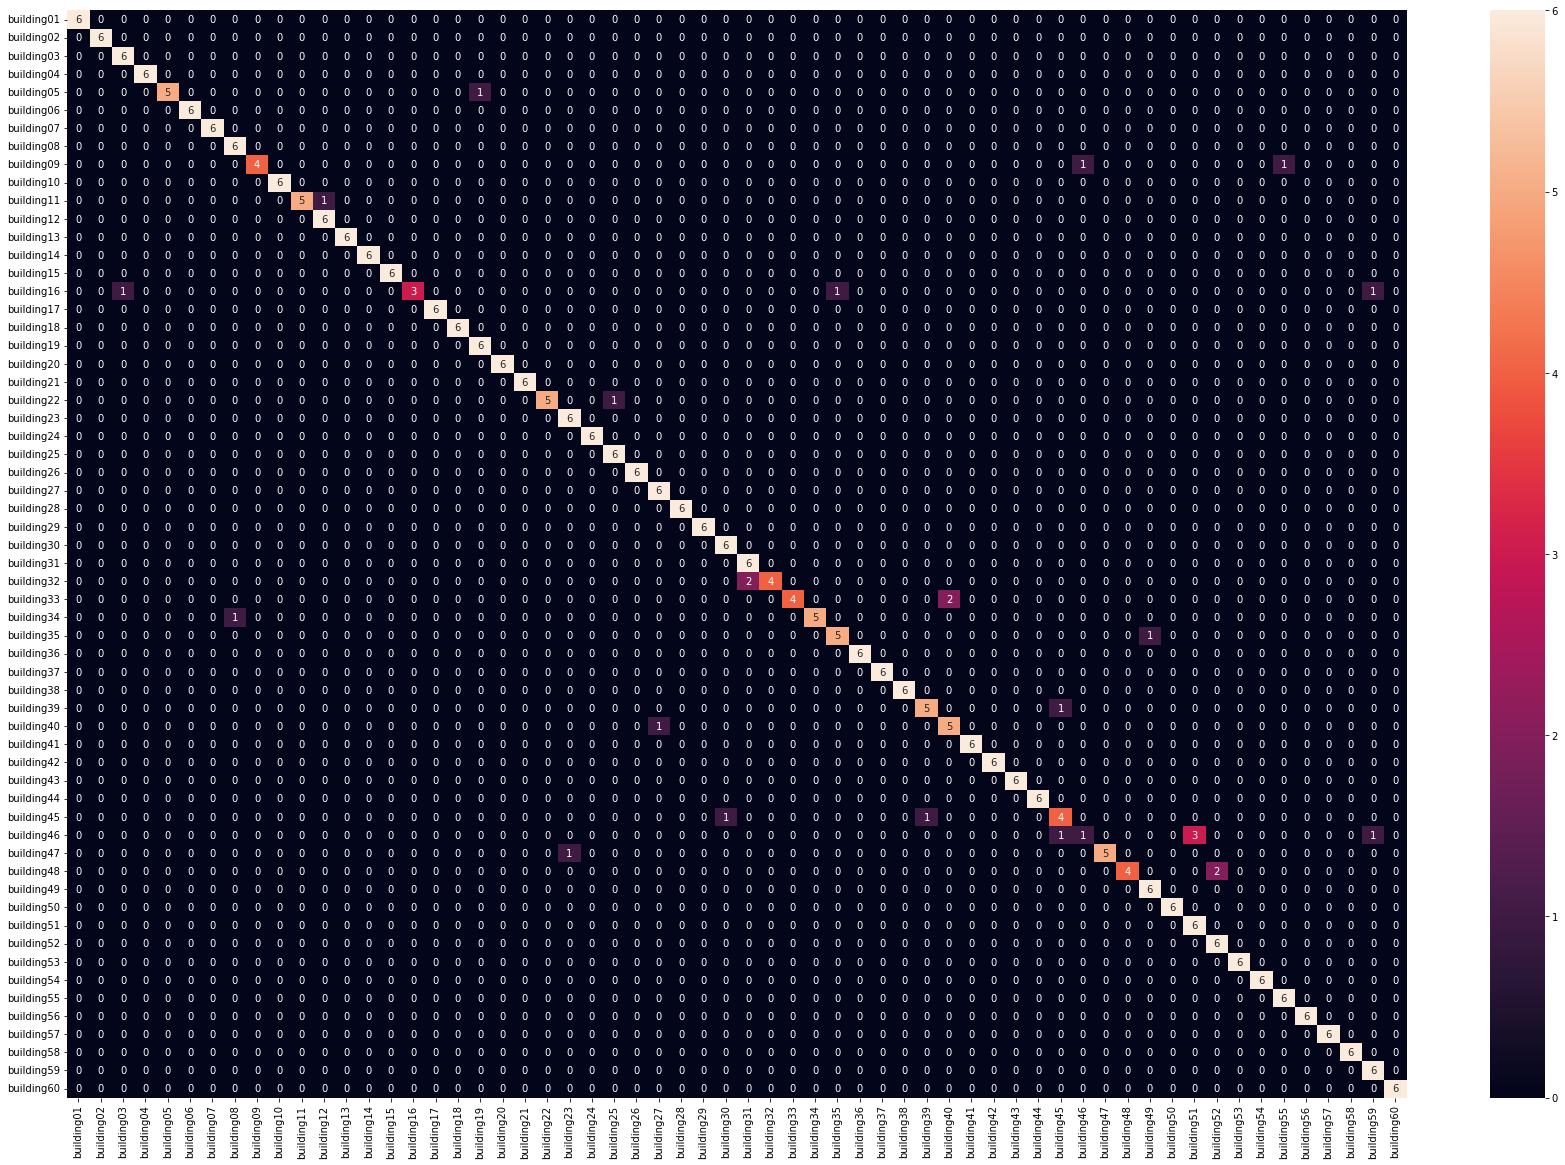

In [169]:
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(y_true)],
                  columns = [i for i in np.unique(y_true)])
plt.figure(figsize = (30,20))
sn.heatmap(df_cm, annot=True)

In [170]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
print(accuracy_score(y_true, y_pred))
print(f1_score(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))

0.9277777777777778
0.9227813852813854
              precision    recall  f1-score   support

  building01       1.00      1.00      1.00         6
  building02       1.00      1.00      1.00         6
  building03       0.86      1.00      0.92         6
  building04       1.00      1.00      1.00         6
  building05       1.00      0.83      0.91         6
  building06       1.00      1.00      1.00         6
  building07       1.00      1.00      1.00         6
  building08       0.86      1.00      0.92         6
  building09       1.00      0.67      0.80         6
  building10       1.00      1.00      1.00         6
  building11       1.00      0.83      0.91         6
  building12       0.86      1.00      0.92         6
  building13       1.00      1.00      1.00         6
  building14       1.00      1.00      1.00         6
  building15       1.00      1.00      1.00         6
  building16       1.00      0.50      0.67         6
  building17       1.00      1.00      1.00